In [ ]:
import tensorflow as tf
import cv2
import random
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [ ]:
def load_file(file_path):
    data = np.load(file_path)
    return data['data']

def expand_greyscale_image_channels(grey_image):
    grey_image_arr = np.array(grey_image)
    grey_image_arr = np.expand_dims(grey_image_arr, 1)
    return grey_image_arr

class DataGenerator:

    def __init__(self, path, set_type):
        """ Returns a set of frames with their associated label.

          Args:
            path: file paths (directory path).
            set_type: type of set to create - train, val or test.
        """
        self.path = path
        self.set_type = set_type
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        data_paths = list(self.path.glob(f'**/{self.set_type}/*.npz'))

        if self.set_type == 'train':
            aug_path = pathlib.Path("/tf/512/dataset_augmentation")
            aug_data_paths = list(aug_path.glob('**/**/*.npz'))
            data_paths = data_paths + aug_data_paths
        classes = [p.parent.parent.name for p in data_paths]
        return data_paths, classes

    def __call__(self):
        data_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(data_paths, classes))

        if self.set_type == 'train':
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = load_file(path)
            video_frames = expand_greyscale_image_channels(video_frames)
            label = self.class_ids_for_name[name] # Encode labels
            yield video_frames, label - 1

In [ ]:
batch_size = 64
num_frames = 29
height = 96
width = 96
word_dataset = pathlib.Path("/tf/512/dataset_more")

output_signature = (tf.TensorSpec(shape = (num_frames, 1, height, width), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(DataGenerator(word_dataset, set_type='train'),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(DataGenerator(word_dataset, set_type='val'),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(DataGenerator(word_dataset, set_type='test'),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

In [ ]:
for frames, labels in train_ds.take(4):
    print(labels)

tf.Tensor(
[ 8 16  0 15 14  7 14 44 40 41 17 19 13 31 12 49 45  3  7 18 46 13 16 34
 40 15  3 20 48 21  4 17  2 49 22 30 17 43 35 41 26 33 19 44 35 46  2 45
 21 34  0 17  2 44  4 23 35 35 32 29  0 30 28  7], shape=(64,), dtype=int16)
tf.Tensor(
[49 37 36 33 23 10  9 43  6 30 44 11 41  2 10 47  4 39 40 24 29 45 40  0
 37 30 30 16 40 15 19 24  9 33 18 15 17  7  5 13 26  2  6 22 37 12 25  9
 38  4 46  9 23 16 39 30 31 20  0 32 14  8 24 20], shape=(64,), dtype=int16)
tf.Tensor(
[ 8  6  5 42 38 26 21 26 24 17 16 49  1 22  7 35 45  7 32 40 46 31 22 29
 10 43 41 24 44 46 37 33 45  9 13 11 15 23 10 23 27  2  9 13 39  3 27 27
 32 34 25 24  8 25 38 14 21 38 25 43  3 28 18 46], shape=(64,), dtype=int16)
tf.Tensor(
[17 38 26 26 39 45 47 27 44 24 23 31  6 33 43 14 21 20 32 18 35 23 19  0
 18 17 37 46 17 45 42 36 11 48 32  4  9 38  1 16 30  4 13 24 37 29 22  9
  1 28  2 22  1 38 24 24 17  8  0  6 49 20 15 20], shape=(64,), dtype=int16)


In [ ]:
for frames, labels in train_ds.take(4):
    print(f"Shape: {frames.shape}")
    print(f"Label: {labels.shape}")

Shape: (64, 29, 1, 96, 96)
Label: (64,)
Shape: (64, 29, 1, 96, 96)
Label: (64,)
Shape: (64, 29, 1, 96, 96)
Label: (64,)
Shape: (64, 29, 1, 96, 96)
Label: (64,)


# Create Model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import MaxPool3D, ReLU, Input, Dense, Dropout, TimeDistributed, GRU, Conv3D, BatchNormalization, Bidirectional

In [ ]:
import math
from tensorflow import keras
from tensorflow.keras import layers

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

In [ ]:
# 2. Buliding a Model

inputs = Input(shape=(num_frames, 1, height, width))
frontend3D = tf.keras.Sequential([
            Conv3D(64, kernel_size=(5, 7, 7), strides=(1, 2, 2), padding='same', use_bias=False, data_format='channels_first'),
            BatchNormalization(),
            ReLU(),
            MaxPool3D(pool_size=(1, 3, 3), strides=(1, 2, 2), padding='valid', data_format='channels_first')
])
conv3d_output = frontend3D(inputs)
conv3d_output = tf.transpose(conv3d_output, (0, 1, 3, 4, 2))

resnet_input_shahpe =  tuple(conv3d_output.shape[2:])
feature_extractor_inputs = Input(shape=resnet_input_shahpe)
feature_extractor_inputs = data_augmentation(feature_extractor_inputs)
feature_extractor_outputs = resnet18(feature_extractor_inputs, num_classes=512)

# Construct CNN model
gru_inp = Model(feature_extractor_inputs, feature_extractor_outputs)
gru_inp.summary()

# Distribute CNN output by timesteps
encoded_frames = TimeDistributed(gru_inp)(conv3d_output)

# Contruct GRU model
encoded_sequence = Bidirectional(GRU(1024, return_sequences=True))(encoded_frames)
encoded_sequence = Dropout(0.5)(encoded_sequence)
encoded_sequence = Bidirectional(GRU(1024, return_sequences=True))(encoded_sequence)
encoded_sequence = Dropout(0.5)(encoded_sequence)
encoded_sequence = Bidirectional(GRU(1024))(encoded_sequence)
encoded_sequence = Dropout(0.5)(encoded_sequence)
outputs = Dense(50, activation="softmax")(encoded_sequence)

# Contruct CNN+GUR model
model = Model(inputs, outputs)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 23, 23, 1)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 29, 29, 1)    0           ['input_24[0][0]']               
                                                                                                  
 conv1 (Conv2D)                 (None, 12, 12, 64)   3136        ['conv1_pad[1][0]']              
                                                                                                  
 bn1 (BatchNormalization)       (None, 12, 12, 64)   256         ['conv1[1][0]']                  
                                                                                           

 layer2.0.bn2 (BatchNormalizati  (None, 3, 3, 128)   512         ['layer2.0.conv2[1][0]']         
 on)                                                                                              
                                                                                                  
 layer2.0.add (Add)             (None, 3, 3, 128)    0           ['layer2.0.downsample.1[1][0]',  
                                                                  'layer2.0.bn2[1][0]']           
                                                                                                  
 layer2.0.relu2 (ReLU)          (None, 3, 3, 128)    0           ['layer2.0.add[1][0]']           
                                                                                                  
 layer2.1.conv1_pad (ZeroPaddin  (None, 5, 5, 128)   0           ['layer2.0.relu2[1][0]']         
 g2D)                                                                                             
          

 g2D)                                                                                             
                                                                                                  
 layer4.0.conv1 (Conv2D)        (None, 1, 1, 512)    1179648     ['layer4.0.conv1_pad[1][0]']     
                                                                                                  
 layer4.0.bn1 (BatchNormalizati  (None, 1, 1, 512)   2048        ['layer4.0.conv1[1][0]']         
 on)                                                                                              
                                                                                                  
 layer4.0.relu1 (ReLU)          (None, 1, 1, 512)    0           ['layer4.0.bn1[1][0]']           
                                                                                                  
 layer4.0.conv2_pad (ZeroPaddin  (None, 3, 3, 512)   0           ['layer4.0.relu1[1][0]']         
 g2D)     

In [ ]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 29, 1, 96, 96)]   0         
                                                                 
 sequential_11 (Sequential)  (None, 64, 1, 23, 23)     454912    
                                                                 
 tf.compat.v1.transpose_8 (T  (None, 64, 23, 23, 1)    0         
 FOpLambda)                                                      
                                                                 
 time_distributed_8 (TimeDis  (None, 64, 512)          11442496  
 tributed)                                                       
                                                                 
 bidirectional_24 (Bidirecti  (None, 64, 2048)         9449472   
 onal)                                                           
                                                          

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)

results = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[reduce_lr, es])

Epoch 1/20
2221/2221 [==============================] - 735s 326ms/step - loss: 2.5291 - accuracy: 0.3119 - val_loss: 1.5232 - val_accuracy: 0.5487 - lr: 1.0000e-04
Epoch 2/20
2221/2221 [==============================] - 724s 325ms/step - loss: 1.2623 - accuracy: 0.6287 - val_loss: 1.1376 - val_accuracy: 0.6634 - lr: 1.0000e-04
Epoch 3/20
2221/2221 [==============================] - 724s 325ms/step - loss: 0.9056 - accuracy: 0.7251 - val_loss: 0.9929 - val_accuracy: 0.7131 - lr: 1.0000e-04
Epoch 4/20
2221/2221 [==============================] - 725s 325ms/step - loss: 0.6882 - accuracy: 0.7879 - val_loss: 0.9162 - val_accuracy: 0.7406 - lr: 1.0000e-04
Epoch 5/20
2221/2221 [==============================] - 725s 326ms/step - loss: 0.5203 - accuracy: 0.8353 - val_loss: 0.9154 - val_accuracy: 0.7456 - lr: 1.0000e-04
Epoch 6/20
2221/2221 [==============================] - 725s 325ms/step - loss: 0.3760 - accuracy: 0.8794 - val_loss: 0.9099 - val_accuracy: 0.7633 - lr: 1.0000e-04
Epoch 7/20

In [ ]:
def plot_history(history):
    """
        Plotting training and validation learning curves.

        Args:
          history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    # ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label = 'train')
    ax2.plot(history.history['val_accuracy'], label = 'test')
    ax2.set_ylabel('Accuracy')
    # ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

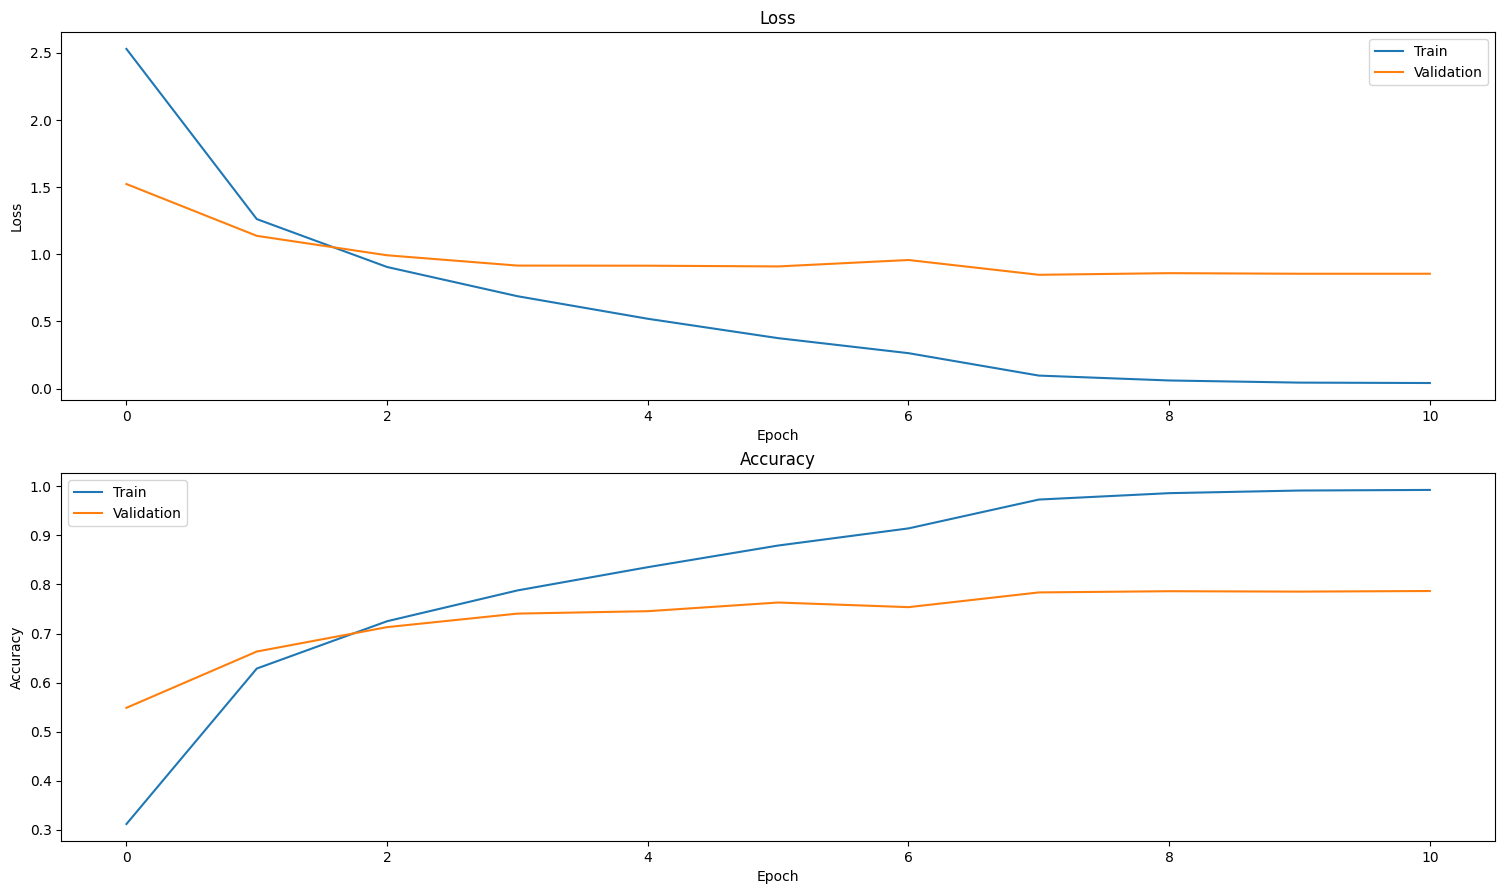

In [ ]:
plot_history(results)

# Evaluate the model

In [ ]:
def get_actual_predicted_labels(dataset, model_param):
    """
        Create a list of actual ground truth values and the predictions from the model.

        Args:
          dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

        Return:
          Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model_param.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(20, 20)})
    sns.set(font_scale=0.9)
    ax.set_title('Confusion matrix of word recognition for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ticks = np.arange(0.5, len(labels), 1)
    plt.xticks(rotation=90, ticks=ticks, labels=labels)
    plt.yticks(rotation=0, ticks=ticks, labels=labels)
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

def print_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f'Accuracy: {round(accuracy*100)}%')
    print(f'Balanced accuracy: {round(balanced_accuracy*100)}%')
    print(f'Precision: {round(precision*100)}%')
    print(f'Recall: {round(recall*100)}%')
    print(f'f1: {round(f1*100)}%')

In [ ]:
fg = DataGenerator(word_dataset, set_type='test')
label_names = list(fg.class_ids_for_name.keys())[1:]

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds, model)

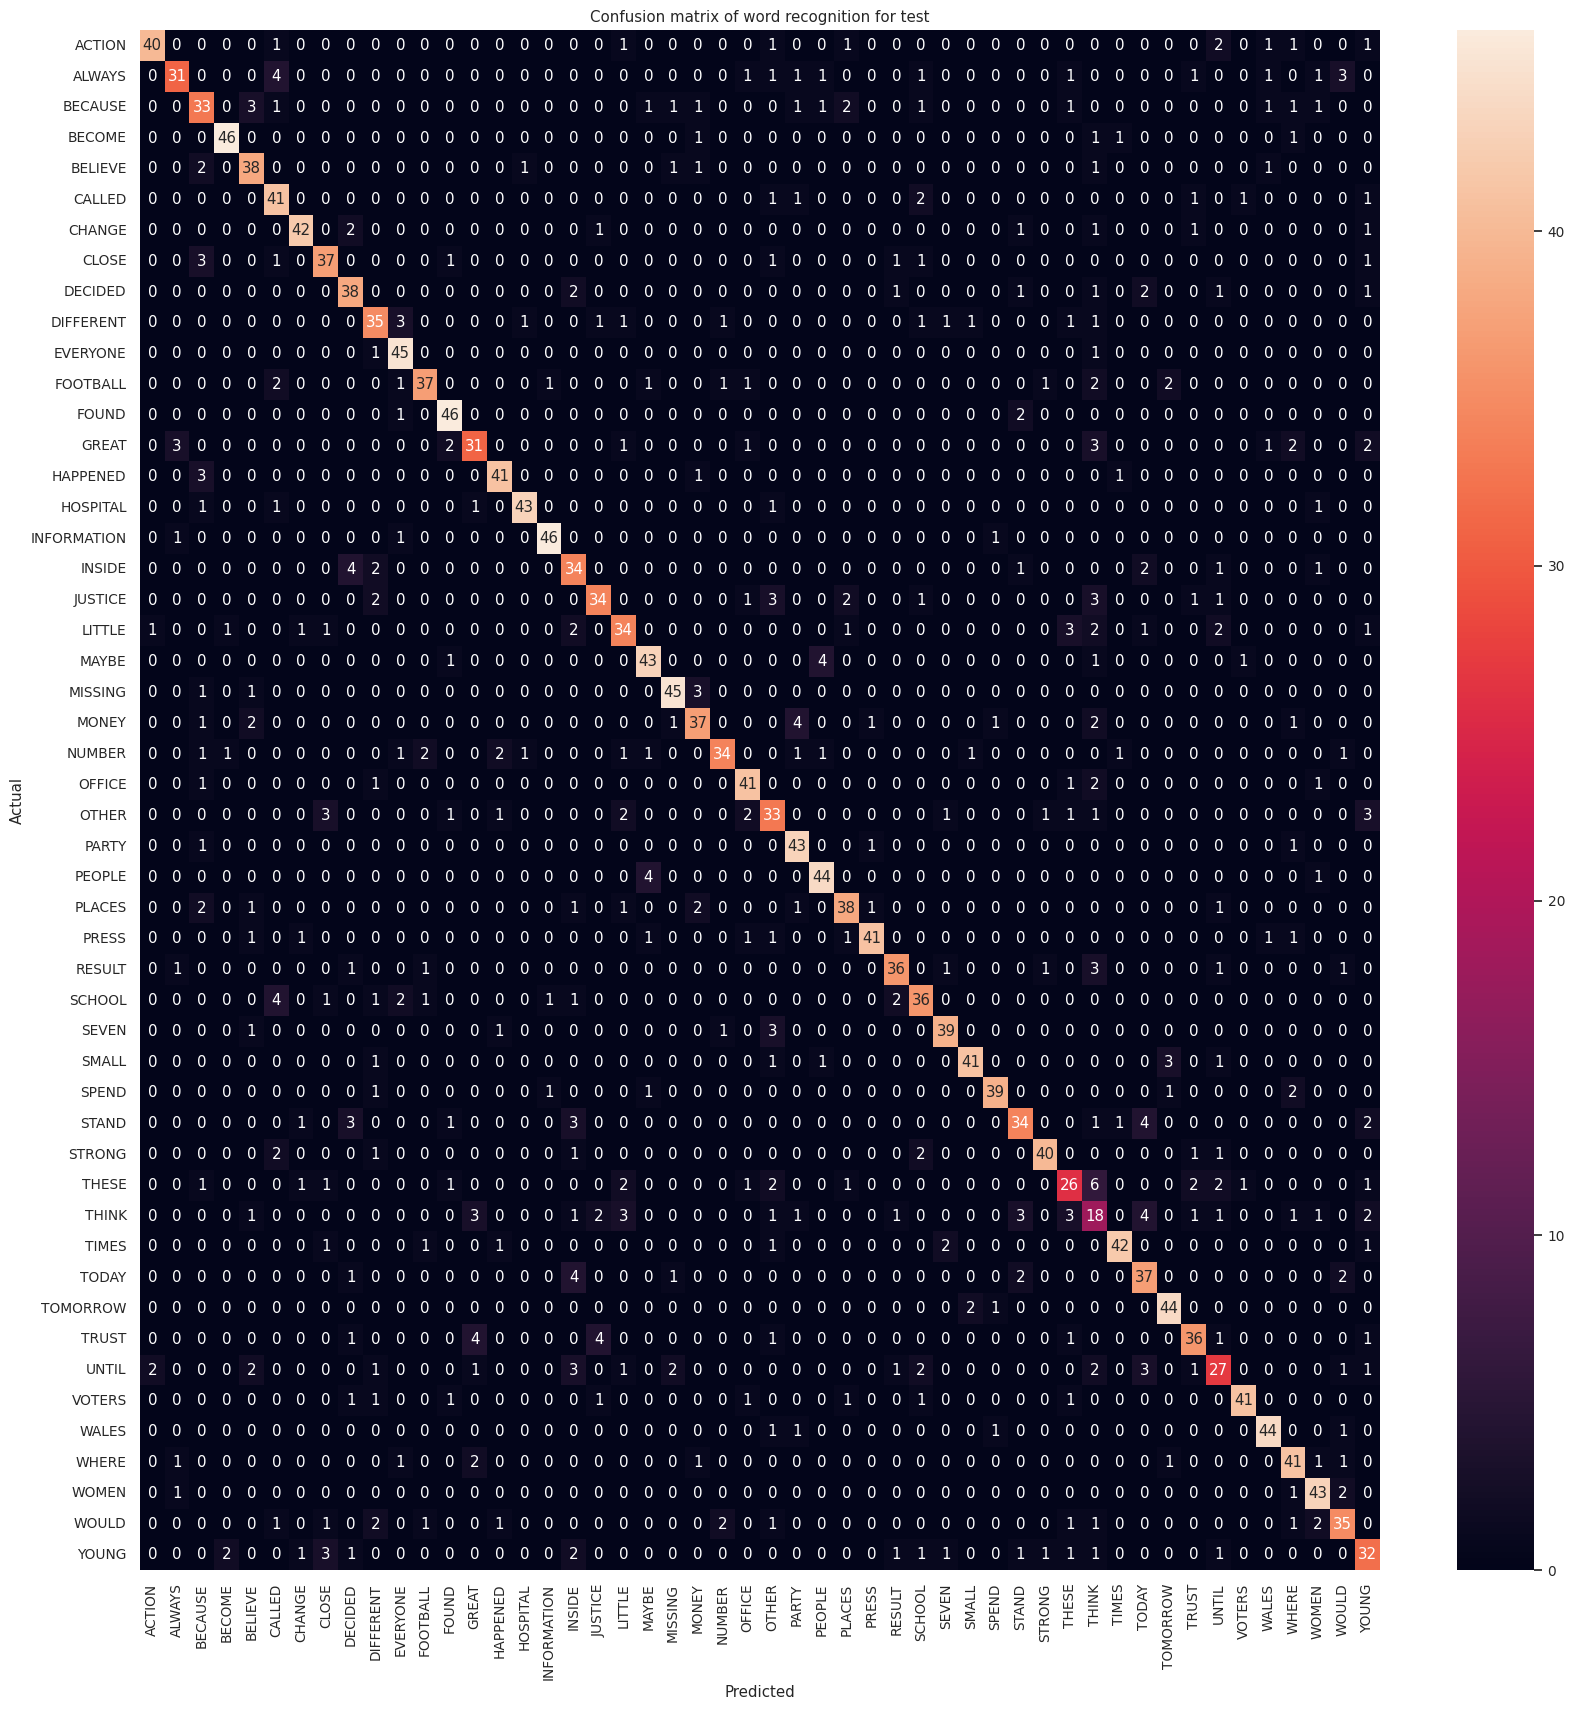

In [ ]:
plot_confusion_matrix(actual, predicted, label_names, 'test')

In [ ]:
print_metrics(actual, predicted)

Accuracy: 79%
Balanced accuracy: 79%
Precision: 80%
Recall: 79%
f1: 79%


In [ ]:
model.save("/tf/512/saved_models/50_words_augmentation_callbacks_79acc_20230602")

INFO:tensorflow:Assets written to: /tf/512/saved_models/50_words_augmentation_callbacks_79acc_20230602/assets


INFO:tensorflow:Assets written to: /tf/512/saved_models/50_words_augmentation_callbacks_79acc_20230602/assets
